In [60]:
import numpy as np
import pandas as pd
import itertools

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.proportion import proportion_confint
from statsmodels.sandbox.stats.multicomp import multipletests 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
data_browser = pd.read_csv('../../ab_browser_test.csv')

In [62]:
data_browser.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [64]:
data_browser.describe()

,userID,n_clicks,n_queries,n_nonclk_queries
count,566134.000000,566134.000000,566134.000000,566134.000000
mean,301377.214027,11.431658,10.720524,4.703987
std,175526.333101,20.251494,16.262827,8.109958
min,1.000000,0.000000,1.000000,0.000000
25%,148627.250000,1.000000,2.000000,1.000000
50%,299362.500000,4.000000,5.000000,2.000000
75%,455698.750000,13.000000,13.000000,6.000000
max,603137.000000,863.000000,665.000000,581.000000


In [65]:
exp_group = data_browser[data_browser['slot'] == 'exp']
control_group = data_browser[data_browser['slot'] == 'control']

Посчитаем, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

In [91]:
print(f"{round(100 * (1 - (exp_group.slot.value_counts()[0] / control_group.slot.value_counts()[0])), 3)}%")

1.045%


In [93]:
round(0.0105 * 100, 3)

1.05

Попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.  
Построим с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп

In [66]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [67]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [68]:
click_exp_cnt = data_browser.n_clicks[data_browser.slot == 'exp']
click_control_cnt = data_browser.n_clicks[data_browser.slot == 'control']

print(f'Медиана «LIMIT_BAR» для «default=0»: {click_exp_cnt.median()}')
print(f'Медиана «LIMIT_BAR» для «default=1»: {click_control_cnt.median()}')

Медиана «LIMIT_BAR» для «default=0»: 5.0
Медиана «LIMIT_BAR» для «default=1»: 4.0


In [69]:
click_exp_cnt_s = np.sort(click_exp_cnt.values)
click_control_cnt_s = np.sort(click_control_cnt.values)

In [70]:
np.random.seed = 0
num_of_samples = 500

In [71]:
click_exp_cnt_boot = get_bootstrap_samples(click_exp_cnt_s, num_of_samples)
click_control_cnt_boot = get_bootstrap_samples(click_control_cnt_s, num_of_samples)

In [72]:
click_exp_cnt_mean_boot = list(map(np.mean, click_exp_cnt_boot))
click_control_cnt_mean_boot = list(map(np.mean, click_control_cnt_boot))
click_exp_cnt_median_boot = list(map(np.median, click_exp_cnt_boot))
click_control_cnt_median_boot = list(map(np.median, click_control_cnt_boot))

delta_mean = list(map(lambda x: x[0] - x[1], zip(click_exp_cnt_mean_boot, click_control_cnt_mean_boot)))
delta_median = list(map(lambda x: x[0] - x[1], zip(click_exp_cnt_median_boot, click_control_cnt_median_boot)))

print("95% дов. интервал разницы средних:",  stat_intervals(delta_mean, 0.05))
print("95% дов. интервал разницы медиан:",  stat_intervals(delta_median, 0.05))

95% дов. интервал разницы средних: [0.2047885  0.41337637]
95% дов. интервал разницы медиан: [1. 1.]


* 95% доверительный интервал для разности средних не  содержит ноль, похоже, средние отличаются статистически значимо
* 95% доверительный интервал для разности медиан не  содержит ноль, похоже, медианы отличаются статистически значимо

Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и  значимым статистически. Последнее утверждение нуждается в дополнительной проверке

c:\users\lazpr\pycharmprojects\basicofstatistic\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\lazpr\pycharmprojects\basicofstatistic\env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


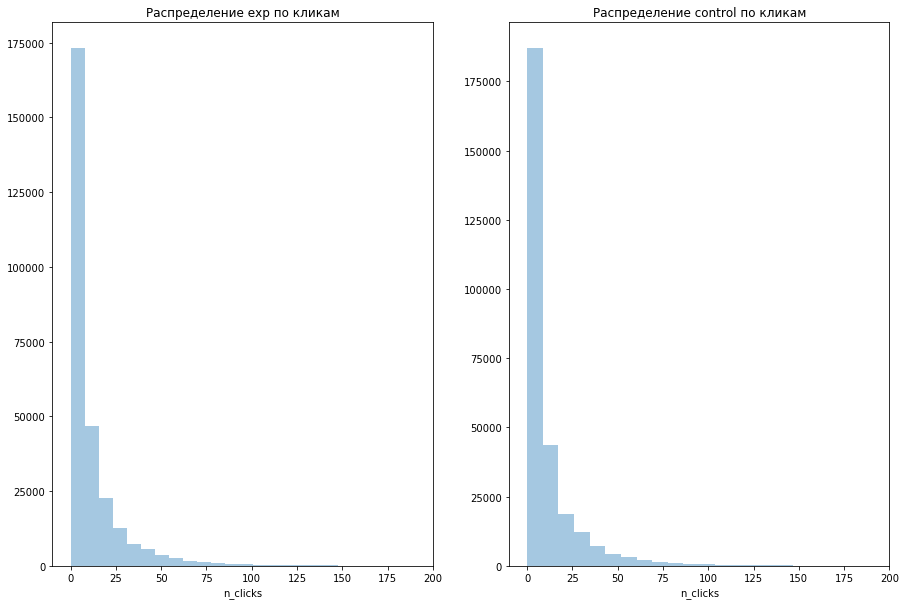

In [20]:
plt.figure(1, figsize=(15,10))
plt.subplot(121)
plt.xlim(-10, 200)
sns.distplot(exp_group.n_clicks, kde=False, rug=False, bins=100)
plt.title('Распределение exp по кликам')

plt.subplot(122)
plt.xlim(-10, 200)
sns.distplot(control_group.n_clicks, kde=False, rug=False, bins=100)
plt.title('Распределение control по кликам')
plt.show()

t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных.

In [21]:
import scipy

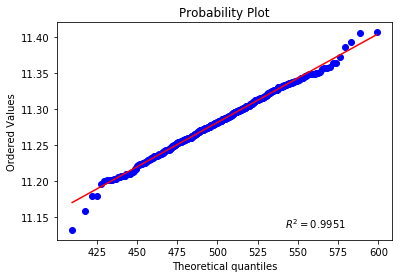

In [73]:
scipy.stats.probplot(click_control_cnt_mean_boot, dist="chi2", 
                     sparams=(len(click_control_cnt_mean_boot)-1), rvalue=True, plot=plt)
plt.show()

In [74]:
click_control_cnt_var = list(map(np.var, click_control_cnt_boot))

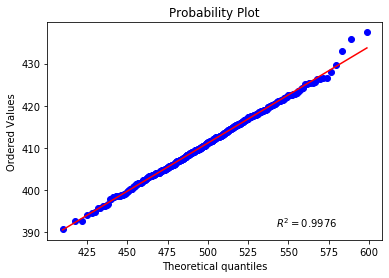

In [75]:
scipy.stats.probplot(click_control_cnt_var, dist="chi2", 
                     sparams=(len(click_control_cnt_var)-1), rvalue=True, plot=plt)
plt.show()

Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

In [76]:
users_nclicks_exp = exp_group.groupby(['userID', 'browser']).sum().loc[:,'n_clicks']
users_nclicks_control = control_group.groupby(['userID', 'browser']).sum().loc[:,'n_clicks']

In [77]:
users_nclicks_exp.head()

userID  browser   
1       Browser #2    23
3       Browser #4     3
5       Browser #4    29
7       Browser #4    54
9       Browser #4     6
Name: n_clicks, dtype: int64

In [78]:
users_nclicks_control.head()

userID  browser    
6       Browser #4     12
8       Browser #4      4
10      Browser #4     22
15      Browser #14     2
23      Browser #4      3
Name: n_clicks, dtype: int64

In [79]:
stats.mannwhitneyu(users_nclicks_exp, users_nclicks_control, alternative='two-sided')

MannwhitneyuResult(statistic=41184125116.0, pvalue=6.247235801369629e-75)

Получившееся значение достигаемого уровня значимости свидетельствует о статистической значимости отличий между  двумя выборками

Проверим, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.  
Для этого применим для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделаем поправку Холма-Бонферрони на множественную проверку с α=0.05.

In [80]:
browser_nclicks_exp = exp_group.groupby(['browser', 'userID']).sum().loc[:,'n_clicks']
browser_nclicks_control = control_group.groupby(['browser', 'userID']).sum().loc[:,'n_clicks']

In [81]:
browsers = np.unique(data_browser.browser)
print('Unique browsers numbers: ' + str(browsers))
print('')

print('Mann-Whitney rank test without multipletest')
mannwhitneyu_p_val = np.empty(browsers.shape[0])
for i, name_br in enumerate(browsers):
    print(name_br),
    _, mannwhitneyu_p_val[i] = stats.mannwhitneyu(browser_nclicks_exp.loc[name_br, :], browser_nclicks_control.loc[name_br, :], alternative='two-sided')
    print('p-value = %.4f' % mannwhitneyu_p_val[i])

print('')
print('Mann-Whitney rank test with multipletest')
_, mw_p_corr, _, _ = multipletests(mannwhitneyu_p_val, alpha = 0.05, method = 'holm')
for i, name_br in enumerate(browsers):
    print(name_br),
    print('p-value = %.4f' % mw_p_corr[i])

Unique browsers numbers: ['Browser #14' 'Browser #17' 'Browser #2' 'Browser #20' 'Browser #22'
 'Browser #4']

Mann-Whitney rank test without multipletest
Browser #14
p-value = 0.0000
Browser #17
p-value = 0.0748
Browser #2
p-value = 0.0545
Browser #20
p-value = 0.9073
Browser #22
p-value = 0.5148
Browser #4
p-value = 0.8152

Mann-Whitney rank test with multipletest
Browser #14
p-value = 0.0000
Browser #17
p-value = 0.2992
Browser #2
p-value = 0.2724
Browser #20
p-value = 1.0000
Browser #22
p-value = 1.0000
Browser #4
p-value = 1.0000


In [82]:
browsers_nonclk_q_exp = exp_group.groupby(['browser']).sum().loc[:,'n_nonclk_queries']
browsers_clk_q_exp = exp_group.groupby(['browser']).sum().loc[:,'n_queries']
browsers_nonclk_q_prop_exp = round(100 * browsers_nonclk_q_exp / browsers_clk_q_exp, 3)

browsers_nonclk_q_ctrl = control_group.groupby(['browser']).sum().loc[:,'n_nonclk_queries']
browsers_clk_q_ctrl = control_group.groupby(['browser']).sum().loc[:,'n_queries']
browsers_nonclk_q_prop_ctrl = round(100 * browsers_nonclk_q_ctrl / browsers_clk_q_ctrl, 3)

print('Control / experimental groups')
for name_br in browsers:
    print(f'{name_br}: {browsers_nonclk_q_prop_ctrl.loc[browsers_nonclk_q_prop_ctrl.index == name_br].values}/{browsers_nonclk_q_prop_exp.loc[browsers_nonclk_q_prop_ctrl.index == name_br].values}')

Control / experimental groups
Browser #14: [57.59]/[43.756]
Browser #17: [36.299]/[36.937]
Browser #2: [45.963]/[44.983]
Browser #20: [40.54]/[38.977]
Browser #22: [40.594]/[39.854]
Browser #4: [46.971]/[45.143]


С помощью анализа, проведенного в предыдущем вопросе, мы показали, что тестируемое изменение приводит к статистически значимому отличию только для одного браузера. Для этого браузера на основе данных о доли некликнутых запросов, заключаем, что тестируемое изменение влияет на пользователей позитивно.